In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.misc  #small helper functions for scientific and image processing tasks
from PIL import Image  #Image is used to open, manipulate, and save image files.
from scipy import ndimage     #N-dimensional image processing
from matplotlib.pyplot import imread  #imread reads an image and converts it to a NumPy array



In [29]:
train_df=h5py.File(r"archive (1)\train_catvnoncat.h5")
test_df=h5py.File(r"archive (1)\test_catvnoncat.h5")

In [30]:
print(list(train_df.keys()))
print(list(test_df.keys()))

['list_classes', 'train_set_x', 'train_set_y']
['list_classes', 'test_set_x', 'test_set_y']


In [31]:
train_set_x_orig=np.array(train_df["train_set_x"][:])

In [32]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [33]:
#dataset loading
def load_dataset():
    train_df=h5py.File(r"archive (1)\train_catvnoncat.h5","r")
    train_set_x_orig=np.array(train_df["train_set_x"][:])
    train_set_y_orig=np.array(train_df["train_set_y"][:])
   
    test_df=h5py.File(r"archive (1)\test_catvnoncat.h5","r")
    test_set_x_orig=np.array(test_df["test_set_x"][:])
    test_set_y_orig=np.array(test_df["test_set_y"][:])

    classes=np.array(test_df['list_classes'][:])

    #to need 2D matrix not a 1D array
    train_set_y_orig=train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y_orig=test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

##### train_x_set= images, train_set_y=labels, list_classes=label name

In [34]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a ' cat' picture.


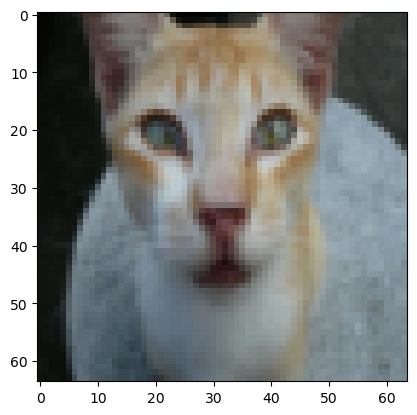

In [35]:
index = 11
a = plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:, index]) + ", it's a ' " + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")
plt.show()


In [36]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=test_set_x_orig.shape[1]

In [37]:
print (f"# of training examples: m_train = {m_train}")
print (f"# of test examples: m_test = {m_test}")
print (f"weight and height and # of channels respectively = {num_px}")
print (f"Shape of train_set_x = {train_set_x_orig.shape}")
print (f"Shape of train_set_y = {train_set_y.shape}")
print (f"Shape of test_set_x = {test_set_x_orig.shape}")
print (f"Shape of test_set_y = {test_set_y.shape}")

# of training examples: m_train = 209
# of test examples: m_test = 50
weight and height and # of channels respectively = 64
Shape of train_set_x = (209, 64, 64, 3)
Shape of train_set_y = (1, 209)
Shape of test_set_x = (50, 64, 64, 3)
Shape of test_set_y = (1, 50)


In [38]:
#reshaping and flattening the image

train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T  #transposing -- each column vector should be one training example

print("train_set_x_flatten shape :"+ str(train_set_x_flatten.shape))
print("train_set_y shape :"+ str(train_set_y.shape))
print("test_set_x_flatten shape :"+ str(test_set_x_flatten.shape))
print("test_set_y shape :"+ str(test_set_y.shape))


train_set_x_flatten shape :(12288, 209)
train_set_y shape :(1, 209)
test_set_x_flatten shape :(12288, 50)
test_set_y shape :(1, 50)


In [39]:
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255  #standardizing dataset

In [40]:
#defining sigmoid (activation)

def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [41]:
#definign model params
def init_params(dim):
    w=np.zeros((dim,1)) #dims= features
    b=0 #bias starting woth zero
    return w,b

In [42]:
# forward and backward propagation
def propagate(w,b,X,Y):

    m=X.shape[1]

    #forward propagation
    A=sigmoid(np.dot(w.T,X)+b)
    cost=-(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))

    #backward propagation
    dw=(1/m)*(np.dot(X,(A-Y).T))
    db=(1/m)*(np.sum(A-Y))

    grads={"dw":dw,"db":db}

    return grads, cost

In [43]:
#applying gradient descent to update weights and biases

def optimize(w,b,X,Y,epochs,lr,print_cost=False):
    costs=[] #to keep the track of loss at every 100 epochs
    for i in range(epochs):
        grads,cost=propagate(w,b,X,Y)

        dw=grads["dw"]
        db=grads["db"]
    
        #to update
        w=w-(lr*dw)
        b=b-(lr*db)

        if i%100==0:
            costs.append(cost)
            print(f"cost after {i} epochs:{cost}")

        params={"w":w,"b":b}

        grads={"dw":dw,"db":db}

        return params, grads, costs


In [44]:
#predicting( inference)
def predict(w,b,X):
    m=X.shape[1]  #columns
    Y_predict=np.zeros((1,m))
    w=w.reshape(X.shape[0],1)

    A=sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):
        if A[0,i]<=0.5:
            Y_predict[0,i]=0 #row 0 and column i
        else:
            Y_predict[0,i]=1

    return Y_predict


In [45]:
def model(X_train,Y_train,X_test,Y_test,epochs,lr,print_cost=False):
    w,b=init_params(X_train.shape[0])
    params,grads,costs=optimize(w,b, X_train, Y_train,epochs,lr,print_cost=print_cost) #training the model

    w=params["w"]
    b=params["b"]  #retrieving learned parameters

    Y_predict_train=predict(w,b,X_train)
    Y_predict_test=predict(w,b,X_test) #making prediction on training data

    #calculating accuracy
    print("train accuracy: {} %". format(100-np.mean(np.abs(Y_predict_train-Y_train))*100)) 
    print("test accuracy: {} %". format(100-np.mean(np.abs(Y_predict_test-Y_test))*100)) 

    #storing model evaluation

    log_reg_model={
        "costs": costs,
        "Y_predict_test": Y_predict_test,
        "Y_predict_train":Y_predict_train,
        "w":w,
        "b":b,
        "learning rate": lr,
        "epoch":epochs

                }
    
    return log_reg_model
    
    


cost after 0 epochs:0.6931471805599453
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %
y=0.0,your algorithm predicts a "non-cat" picture.


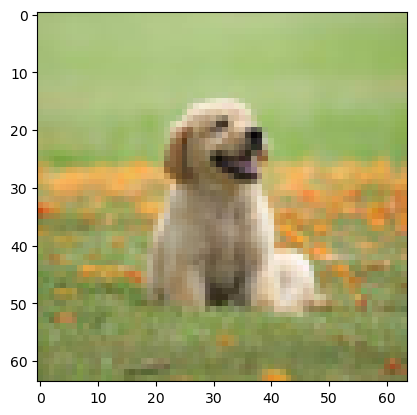

In [49]:
#activating the logistic regression function
myModel= model(train_set_x,train_set_y,test_set_x,test_set_y,epochs=10000,lr=0.001,print_cost=True)

img=Image.open("download .jpg")
img = img.resize((num_px, num_px))
data = np.asarray(img)
data = data / 255.0  

data1 = data.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(myModel["w"], myModel["b"], data1)

plt.imshow(img)
print("y="+str(np.squeeze(my_predicted_image))+",your algorithm predicts a \""+ classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")+"\" picture.")